In [3]:
import numpy as np 
import matplotlib.pyplot as plt
import os
import sys
import time 
from scipy import fft, arange, signal

In [4]:
total_start_time = time.time()
start_time = time.time()

# parameter to determined
Dm = 15.64
criteria_Dm = 0.8
phi, eqWCA, Ca, D = 5, 0.8, 0.03, 0
dim = [144, 24, 144]

def getCOM(path):
    temp_positionCOM = []
    with open(path) as f:
        for index, line in enumerate(f):
            if index > 0: temp_positionCOM.append([float(i)%dim[dim_index] for dim_index, i in enumerate(line.split()[1: 4])])
    positionCOM = np.zeros((3, len(temp_positionCOM)))
    for i in range(len(temp_positionCOM)):
        positionCOM[:, i] = temp_positionCOM[i]
    return positionCOM

if phi == 5:
    job_name = job_name = "phi{}/Re0.1/eqWCA{}/h24phi{}Re0.1Ca{}D{}eqWCA{}".format(phi, eqWCA, phi, Ca, D, eqWCA)
else:
    job_name = "phi{}/eqWCA{}/h24phi{}Re0.1Ca{}D{}eqWCA{}".format(phi, eqWCA, phi, Ca, D, eqWCA)
path_job = "/Users/andrewliu/remote_disk/{}/data".format(job_name)

particle_numbers = 0
for fn in os.listdir(path_job):
    if fn.split('.')[0] == "sphere_props": particle_numbers += 1

timesteps = getCOM(path_job+'/sphere_props.0.dat').shape[1] # WriteProps = 2000
COMs = np.zeros((particle_numbers, 3, timesteps))
print("number of particles =", particle_numbers)

for i in range(particle_numbers):
    COMs[i, :, :] = getCOM(path_job+'/sphere_props.{}.dat'.format(i))
print('Time elpased to collect COM data = ', time.time()-start_time)

number of particles = 33
Time elpased to collect COM data =  40.14094519615173


In [5]:
start_time = time.time()


bead_number = 642 # 642 beads per particle
time_index = [] # every WriteConfig timesteps will generate a bond0.vtk, len(time_index) = timesteps/2
for fn in os.listdir(path_job):
    if fn.split('_')[0] == "bond0": time_index.append(((fn.split('_')[1]).split('.')[0])[1:])
sorted(time_index, key= lambda k: int(k))

def getYpos(time):
    f = open(path_job+"/bond0_t{}.vtk".format(time))
    data = f.readlines()
    entering_data = 0
    for line_index, line in enumerate(data):
        if line[0].isdigit() and entering_data == 0:
            end_pos_format = line_index
            entering_data = 1
            break
    Ypos = np.zeros(particle_numbers)
    for i in range(particle_numbers):
        Ypos[i] = float(data[i*bead_number+end_pos_format].split()[1])
    f.close()
    return(Ypos)

def getYpos2(time):
    reader = vtk.vtkUnstructuredGridReader()
    reader.SetFileName(path_job+"/bond0_t{}.vtk".format(time))
    reader.Update() # Needed because of GetScalarRange
    points = np.array( reader.GetOutput().GetPoints().GetData() )
    Ypos = points[::int(bead_number/6), 1]
    return(Ypos)

interval = 200
Ypos_t = np.zeros((int(particle_numbers), interval))
for i in range(interval):
    Ypos_t[:, i] = getYpos(time_index[int(timesteps/4)+i]) # from the middle of bond0.vtks
    

print('Time elpased to collect bond0.vtk data = ', time.time()-start_time)

Time elpased to collect bond0.vtk data =  983.8264603614807


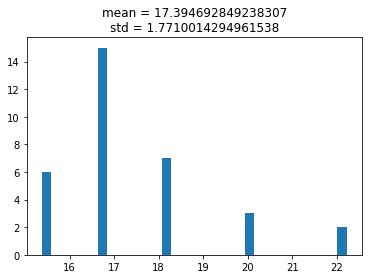

Rotation time =  35
Time elpased to calculate rotation time =  0.3497319221496582


In [6]:
# Calculate the rotating period here

start_time = time.time()

Periods = np.zeros(particle_numbers)
for i in range(particle_numbers):
    Ypos_t_norm = Ypos_t[i, :] - np.mean(Ypos_t[i, :])
    f, Pxx = signal.periodogram(Ypos_t_norm, fs = 1, window='hanning', scaling='spectrum')
    Periods[i] = 1/(f[np.argsort(Pxx)[-1]])

rotation_time = int(round(np.mean(Periods)*2)) # WriteConfig/WriteProps = 4000/2000 = 2

plt.hist(Periods, bins = particle_numbers)
plt.title("mean = {}\nstd = {}".format(np.mean(Periods), np.std(Periods)))
plt.show()
print("Rotation time = ",rotation_time)
print('Time elpased to calculate rotation time = ', time.time()-start_time)

NameError: name 'period' is not defined

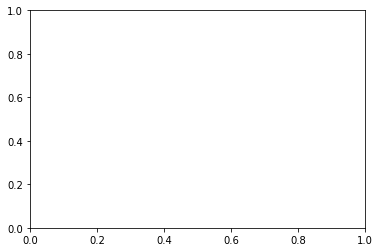

In [7]:
start_time = time.time()

number_of_pairs = int((particle_numbers-1)*particle_numbers/2)
diffpos = np.zeros((number_of_pairs, timesteps))
indice_pairs = np.zeros((number_of_pairs, 2))

count = 0
for i in range(particle_numbers-1):
    for j in range(i+1, particle_numbers):
        indice_pairs[count, 0], indice_pairs[count, 1] = i, j
        diffpos[count, :] = np.linalg.norm((COMs[i, :, :] - COMs[j, :, :]), axis=0)
        count += 1       

# coorect diffpos here
for k in range(number_of_pairs):
    for t in range(1, timesteps):
        if (diffpos[k, t-1] < 2*Dm) and (diffpos[k, t] > 6*Dm): # one of the two RBCs cross the boundry
            i, j = int(indice_pairs[k,0]), int(indice_pairs[k,1])
            correct_current_pos = COMs[j, :, t] # modify the position of the latter one of the two RBCs
            
            # modify the x coordinate 
            if (COMs[i, 0, t]-int(dim[0]/2))*(COMs[j, 0, t]-int(dim[0]/2)) < 0:
                if (COMs[j, 0, t]-int(dim[0]/2)) < 0: correct_current_pos[0] += int(dim[0])
                else: correct_current_pos[0] -= int(dim[0])
            
            # modify the z coordinate 
            if (COMs[i, 2, t]-int(dim[1]/2))*(COMs[j, 2, t]-int(dim[1]/2)) < 0:
                if (COMs[j, 2, t]-int(dim[1]/2)) < 0: correct_current_pos[2] += int(dim[1])
                else: correct_current_pos[2] -= int(dim[1])
            
            # calculate the correct diff COM distance here
            diffpos[k, t] = np.linalg.norm(COMs[i, :, t] - correct_current_pos)
                
criteria_Ts = [1, 1.25, 1.5]
fig, ax1 = plt.subplots()
number_of_doublets = np.zeros(timesteps - period)
for criteria_T in criteria_Ts:
    period = criteria_T*rotation_time 
    for t in range(timesteps - period):
        for i in range(number_of_pairs):
            if max(diffpos[i,t:t+period]) < criteria_Dm*Dm: number_of_doublets[t] += 1
    ax1.plot(np.array(list(range(timesteps - period)))*2000, number_of_doublets/particle_numbers, 
             label = "{}t_rot".format(criteria_T)) # WriteProps = 2000
ax1.set_xlabel("timesteps")
ax1.set_ylabel("doublet fraction")
ax1.set_title("h=24, phi={}, Re=0.1, Ca={}, D={}, eqWCA={}, r = {}Dm ".format(phi, Ca, D, eqWCA, criteria_Dm))
ax1.legend()
ax2 = ax1.twinx()
mn, mx = ax1.get_ylim()
ax2.set_ylim(mn*particle_numbers, mx*particle_numbers)
ax2.set_ylabel('# of doublets')
#plt.savefig("./Pictures/h24phi{}Re0.1Ca{}D{}eqWCA{}_r{}T{}_corrected.png".format(phi, Ca, D, eqWCA, criteria_Dm, criteria_T), dpi = 300)
print('Time elpased to calculate the number of doublets = ', time.time()-start_time)
print('Total time elapsed = ', time.time()-total_start_time)